*Alonso Evan*

*02 June 2020*


----------

# Real or Not? NLP with Disaster Tweets

In this competition, you’re challenged to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t.

![](https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcTigQWzoYCNiDyrz1BN4WTf2X2k9OZ_yvW-FsmcIMsdS9fppNmh)

<div class="list-group" id="list-tab" role="tablist">
  <h1 class="list-group-item list-group-item-action active" data-toggle="list"  role="tab" aria-controls="home">&nbsp;Table of Contents:</h1>
  <a class="list-group-item list-group-item-action" data-toggle="list" href="#1" role="tab" aria-controls="profile">Import packages<span class="badge badge-primary badge-pill">1</span></a>
  <a class="list-group-item list-group-item-action" data-toggle="list" href="#2" role="tab" aria-controls="messages"> Data Exploration<span class="badge badge-primary badge-pill">2</span></a>
  <a class="list-group-item list-group-item-action"  data-toggle="list" href="#3" role="tab" aria-controls="settings">Deep Learning methods<span class="badge badge-primary badge-pill">3</span></a>
  <a class="list-group-item list-group-item-action"  data-toggle="list" href="#4" role="tab" aria-controls="settings">Machine Learning methods<span class="badge badge-primary badge-pill">4</span></a>
  <a class="list-group-item list-group-item-action" data-toggle="list" href="#5" role="tab" aria-controls="settings">Model performances<span class="badge badge-primary badge-pill">5</span></a> 
  <a class="list-group-item list-group-item-action" data-toggle="list" href="#6" role="tab" aria-controls="settings">First submission to Kaggle<span class="badge badge-primary badge-pill">6</span></a> 
  <a class="list-group-item list-group-item-action" data-toggle="list" href="#7" role="tab" aria-controls="settings">Models performances<span class="badge badge-primary badge-pill">5</span></a> 
  <a class="list-group-item list-group-item-action" data-toggle="list" href="#8" role="tab" aria-controls="settings">Second submission to Kaggle<span class="badge badge-primary badge-pill">6</span></a> 
</div>

Twitter has become an important communication channel in times of emergency. The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

In this competition, we’re challenged to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t. We have access to a dataset of 10,000 tweets that were hand classified.

<a id="1"></a> <br>
## 1. Import packages

In [3]:
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from collections import  Counter
plt.style.use('ggplot')
stop=set(stopwords.words('english'))
import re
from nltk.tokenize import word_tokenize

import string
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam

import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import EnglishStemmer
import pandas as pd

#https://stackoverflow.com/questions/62465620/error-keras-requires-tensorflow-2-2-or-higher
#keras error

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense , Input , LSTM , Embedding, Dropout , Activation, GRU, Flatten
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model, Sequential
from keras.layers import Convolution1D
from keras import initializers, regularizers, constraints, optimizers, layers

<a id="2"></a> <br>

## 2. Data Exploration

In [13]:
train= pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
train.head(3)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1


<ul style="list-style-type:square;">
  <li><span class="label label-default">id</span> a unique identifier for each tweet</li>
  <li><span class="label label-default">text </span> the text of the tweet</li>
  <li><span class="label label-default">location</span>  the location the tweet was sent from (may be blank)</li>
    <li><span class="label label-default">keyword</span>  a particular keyword from the tweet (may be blank)</li>
    <li><span class="label label-default">target</span>  in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)</li>
</ul>


*Location* :

Can this field help? lets see what are the most common locations and how many there are. This field contains users inputs and were not automatically generated. take a look at it. it's very dirty and even same places don't have the same name. but first it's good to take a look at the common places people tweet from.

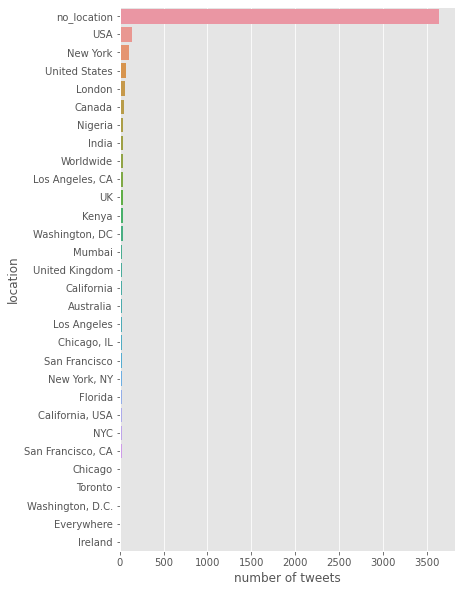

In [89]:
df_concat = pd.concat([train, test], axis = 0) 

for df in [train, test, df_concat]:


    df.keyword.fillna('no_keyword', inplace = True)

    df.location.fillna('no_location', inplace = True)



# top 30 locations in the dataset

top_30 = df_concat.groupby(['location']).count().text.sort_values(ascending = False)[:30]

# plot the top 30

plt.figure(figsize = (6,10))
sns.barplot(x = top_30, y = top_30.index);
plt.xlabel('number of tweets');

The list of common places include strings like 'earth' or 'Everywhere'! It's because this field is the users input and were not automatically generated and is very dirty. we'll get rid of it right away.

In [10]:
test.head(3)

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."


In [8]:
print('There are {} rows and {} colums in train'.format(train.shape[0], train.shape[1]))

print('There are {} rows and {} colums in test'.format(test.shape[0], test.shape[1]))

There are 7613 rows and 5 colums in train
There are 3263 rows and 4 colums in test


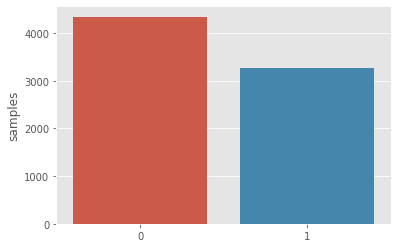

In [13]:
x = train.target.value_counts()
sns.barplot(x.index,x)
plt.gca().set_ylabel('samples');

Oh,as expected ! There is a class distribution.There are more tweets with class 0 ( No disaster) than class 1 ( disaster tweets) but not that much


First,we will do very basic analysis,that is character level,word level and sentence level analysis.

*Number of characters in tweets*

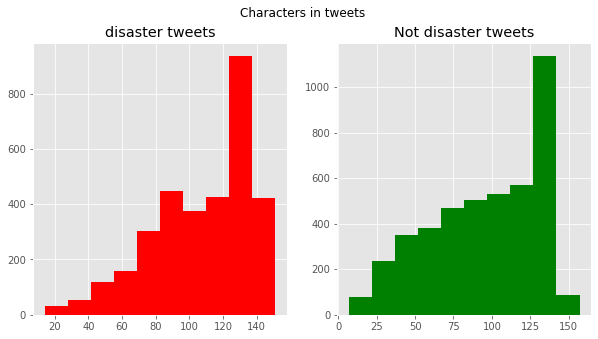

In [15]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=train[train['target']==1]['text'].str.len()
ax1.hist(tweet_len,color='red')
ax1.set_title('disaster tweets')
tweet_len=train[train['target']==0]['text'].str.len()
ax2.hist(tweet_len,color='green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Characters in tweets')
plt.show()

The distribution of both seems to be almost same.120 t0 140 characters in a tweet are the most common among both.

*Number of words in a tweet*

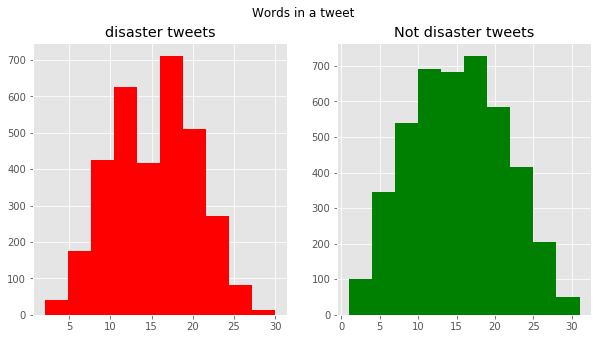

In [16]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=train[train['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len,color='red')
ax1.set_title('disaster tweets')
tweet_len=train[train['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Words in a tweet')
plt.show()

*Average word length in a tweet*

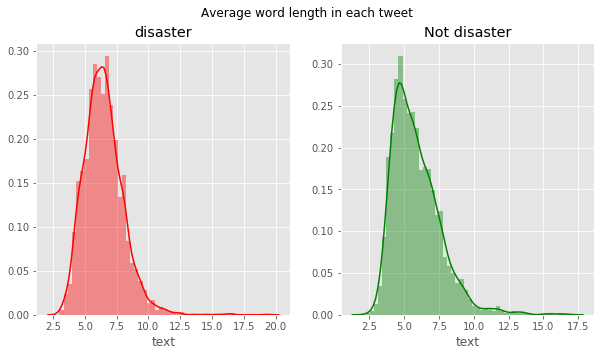

In [18]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
word=train[train['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('disaster')
word=train[train['target']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Not disaster')
fig.suptitle('Average word length in each tweet');

Now ve can focus on the modelling aspect, first we will try **Deep Learning methods** and after we will try **Machine Learning methods**.

<a id="3"></a> <br>
## 3. Deep Learning methods

### 3.1. Basic NLP Techniques
<img src='https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcT6TkPpD8nWsbTVa9ExwfCQUnFmzkNE8zjZJ3uXSaBVd09ErhvZ' alt='text preprocessing' style='float:left' width=50% >
<div style='clear:both'></div>

I tried with Word Embeddings but it was way too long to process the Deep Learning Models so I did it without that.

In [4]:
from nltk.corpus import stopwords
import nltk
import re
import string, collections
from nltk.stem.snowball import EnglishStemmer
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words('english'))
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
stemmer = EnglishStemmer()
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower() #make text lowercase and fill na
    text = re.sub('\[.*?\]', '', text) 
    text = re.sub('\\n', '',str(text))
    text = re.sub("\[\[User.*",'',str(text))
    text = re.sub("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}",'',str(text))
    text = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text) #remove hyperlinks
    text = re.sub(r'\:(.*?)\:', '', text) #remove emoticones
    text = re.sub(r'[\w\.-]+@[\w\.-]+', '', str(text)) #remove email
    text = re.sub(r'(?<=@)\w+', '', text) #remove @
    text = re.sub(r'[0-9]+', '', text) #remove numbers
    text = re.sub("[^A-Za-z0-9 ]", '', text) #remove non alphanumeric like ['@', '#', '.', '(', ')']
    text = re.sub(r'[!"\$%&\'()*+,\-.\/:;=#@?\[\\\]^_`{|}~]*', '', text) #remove punctuations from sentences
    text = re.sub('<.*?>+', '', str(text))
    text = re.sub('[%s]' % re.escape(string.punctuation), '', str(text))
    text = re.sub('\w*\d\w*', '', str(text))
    text = tokenizer.tokenize(text)
    text = [word for word in text if not word in stop_words]
    #text = [lemmatizer.lemmatize(word) for word in text]
    text = [stemmer.stem(word) for word in text]
    final_text = ' '.join( [w for w in text if len(w)>1] ) #remove word with one letter
    return final_text


train['clean_text'] = train['text'].apply(lambda x : clean_text(x))

Before modeling, we will aplly this preprocessing I found on this notebook :
    
https://www.kaggle.com/tuckerarrants/nlp-with-twitter-eda-glove-keras-rnns?fbclid=IwAR06tf2sh831TCqItHZzPl7EfGBFSBsdSxd_qk-3Kg55bOkmKbRPimoBG3M

It's very specific at this database so don't use it for another problem.

In [5]:
def clean(tweet):
    tweet = re.sub(r"he's", "he is", tweet)
    tweet = re.sub(r"there's", "there is", tweet)
    tweet = re.sub(r"We're", "We are", tweet)
    tweet = re.sub(r"That's", "That is", tweet)
    tweet = re.sub(r"won't", "will not", tweet)
    tweet = re.sub(r"they're", "they are", tweet)
    tweet = re.sub(r"Can't", "Cannot", tweet)
    tweet = re.sub(r"wasn't", "was not", tweet)
    tweet = re.sub(r"aren't", "are not", tweet)
    tweet = re.sub(r"isn't", "is not", tweet)
    tweet = re.sub(r"What's", "What is", tweet)
    tweet = re.sub(r"i'd", "I would", tweet)
    tweet = re.sub(r"should've", "should have", tweet)
    tweet = re.sub(r"where's", "where is", tweet)
    tweet = re.sub(r"we'd", "we would", tweet)
    tweet = re.sub(r"i'll", "I will", tweet)
    tweet = re.sub(r"weren't", "were not", tweet)
    tweet = re.sub(r"They're", "They are", tweet)
    tweet = re.sub(r"let's", "let us", tweet)
    tweet = re.sub(r"it's", "it is", tweet)
    tweet = re.sub(r"can't", "cannot", tweet)
    tweet = re.sub(r"don't", "do not", tweet)
    tweet = re.sub(r"you're", "you are", tweet)
    tweet = re.sub(r"i've", "I have", tweet)
    tweet = re.sub(r"that's", "that is", tweet)
    tweet = re.sub(r"i'll", "I will", tweet)
    tweet = re.sub(r"doesn't", "does not", tweet)
    tweet = re.sub(r"i'd", "I would", tweet)
    tweet = re.sub(r"didn't", "did not", tweet)
    tweet = re.sub(r"ain't", "am not", tweet)
    tweet = re.sub(r"you'll", "you will", tweet)
    tweet = re.sub(r"I've", "I have", tweet)
    tweet = re.sub(r"Don't", "do not", tweet)
    tweet = re.sub(r"I'll", "I will", tweet)
    tweet = re.sub(r"I'd", "I would", tweet)
    tweet = re.sub(r"Let's", "Let us", tweet)
    tweet = re.sub(r"you'd", "You would", tweet)
    tweet = re.sub(r"It's", "It is", tweet)
    tweet = re.sub(r"Ain't", "am not", tweet)
    tweet = re.sub(r"Haven't", "Have not", tweet)
    tweet = re.sub(r"Could've", "Could have", tweet)
    tweet = re.sub(r"youve", "you have", tweet)
    tweet = re.sub(r"haven't", "have not", tweet)
    tweet = re.sub(r"hasn't", "has not", tweet)
    tweet = re.sub(r"There's", "There is", tweet)
    tweet = re.sub(r"He's", "He is", tweet)
    tweet = re.sub(r"It's", "It is", tweet)
    tweet = re.sub(r"You're", "You are", tweet)
    tweet = re.sub(r"I'M", "I am", tweet)
    tweet = re.sub(r"shouldn't", "should not", tweet)
    tweet = re.sub(r"wouldn't", "would not", tweet)
    tweet = re.sub(r"i'm", "I am", tweet)
    tweet = re.sub(r"I'm", "I am", tweet)
    tweet = re.sub(r"Isn't", "is not", tweet)
    tweet = re.sub(r"Here's", "Here is", tweet)
    tweet = re.sub(r"you've", "you have", tweet)
    tweet = re.sub(r"we're", "we are", tweet)
    tweet = re.sub(r"what's", "what is", tweet)
    tweet = re.sub(r"couldn't", "could not", tweet)
    tweet = re.sub(r"we've", "we have", tweet)
    tweet = re.sub(r"who's", "who is", tweet)
    tweet = re.sub(r"y'all", "you all", tweet)
    tweet = re.sub(r"would've", "would have", tweet)
    tweet = re.sub(r"it'll", "it will", tweet)
    tweet = re.sub(r"we'll", "we will", tweet)
    tweet = re.sub(r"We've", "We have", tweet)
    tweet = re.sub(r"he'll", "he will", tweet)
    tweet = re.sub(r"Y'all", "You all", tweet)
    tweet = re.sub(r"Weren't", "Were not", tweet)
    tweet = re.sub(r"Didn't", "Did not", tweet)
    tweet = re.sub(r"they'll", "they will", tweet)
    tweet = re.sub(r"they'd", "they would", tweet)
    tweet = re.sub(r"DON'T", "DO NOT", tweet)
    tweet = re.sub(r"they've", "they have", tweet)
    
    #correct some acronyms while we are at it
    tweet = re.sub(r"tnwx", "Tennessee Weather", tweet)
    tweet = re.sub(r"azwx", "Arizona Weather", tweet)  
    tweet = re.sub(r"alwx", "Alabama Weather", tweet)
    tweet = re.sub(r"wordpressdotcom", "wordpress", tweet)      
    tweet = re.sub(r"gawx", "Georgia Weather", tweet)  
    tweet = re.sub(r"scwx", "South Carolina Weather", tweet)  
    tweet = re.sub(r"cawx", "California Weather", tweet)
    tweet = re.sub(r"usNWSgov", "United States National Weather Service", tweet) 
    tweet = re.sub(r"MH370", "Malaysia Airlines Flight 370", tweet)
    tweet = re.sub(r"okwx", "Oklahoma City Weather", tweet)
    tweet = re.sub(r"arwx", "Arkansas Weather", tweet)  
    tweet = re.sub(r"lmao", "laughing my ass off", tweet)  
    tweet = re.sub(r"amirite", "am I right", tweet)
    
    #and some typos/abbreviations
    tweet = re.sub(r"w/e", "whatever", tweet)
    tweet = re.sub(r"w/", "with", tweet)
    tweet = re.sub(r"USAgov", "USA government", tweet)
    tweet = re.sub(r"recentlu", "recently", tweet)
    tweet = re.sub(r"Ph0tos", "Photos", tweet)
    tweet = re.sub(r"exp0sed", "exposed", tweet)
    tweet = re.sub(r"<3", "love", tweet)
    tweet = re.sub(r"amageddon", "armageddon", tweet)
    tweet = re.sub(r"Trfc", "Traffic", tweet)
    tweet = re.sub(r"WindStorm", "Wind Storm", tweet)
    tweet = re.sub(r"16yr", "16 year", tweet)
    tweet = re.sub(r"TRAUMATISED", "traumatized", tweet)
    
    #hashtags and usernames
    tweet = re.sub(r"IranDeal", "Iran Deal", tweet)
    tweet = re.sub(r"ArianaGrande", "Ariana Grande", tweet)
    tweet = re.sub(r"camilacabello97", "camila cabello", tweet) 
    tweet = re.sub(r"RondaRousey", "Ronda Rousey", tweet)     
    tweet = re.sub(r"MTVHottest", "MTV Hottest", tweet)
    tweet = re.sub(r"TrapMusic", "Trap Music", tweet)
    tweet = re.sub(r"ProphetMuhammad", "Prophet Muhammad", tweet)
    tweet = re.sub(r"PantherAttack", "Panther Attack", tweet)
    tweet = re.sub(r"StrategicPatience", "Strategic Patience", tweet)
    tweet = re.sub(r"socialnews", "social news", tweet)
    tweet = re.sub(r"IDPs:", "Internally Displaced People :", tweet)
    tweet = re.sub(r"ArtistsUnited", "Artists United", tweet)
    tweet = re.sub(r"ClaytonBryant", "Clayton Bryant", tweet)
    tweet = re.sub(r"jimmyfallon", "jimmy fallon", tweet)
    tweet = re.sub(r"justinbieber", "justin bieber", tweet)  
    tweet = re.sub(r"Time2015", "Time 2015", tweet)
    tweet = re.sub(r"djicemoon", "dj icemoon", tweet)
    tweet = re.sub(r"LivingSafely", "Living Safely", tweet)
    tweet = re.sub(r"FIFA16", "Fifa 2016", tweet)
    tweet = re.sub(r"thisiswhywecanthavenicethings", "this is why we cannot have nice things", tweet)
    tweet = re.sub(r"bbcnews", "bbc news", tweet)
    tweet = re.sub(r"UndergroundRailraod", "Underground Railraod", tweet)
    tweet = re.sub(r"c4news", "c4 news", tweet)
    tweet = re.sub(r"MUDSLIDE", "mudslide", tweet)
    tweet = re.sub(r"NoSurrender", "No Surrender", tweet)
    tweet = re.sub(r"NotExplained", "Not Explained", tweet)
    tweet = re.sub(r"greatbritishbakeoff", "great british bake off", tweet)
    tweet = re.sub(r"LondonFire", "London Fire", tweet)
    tweet = re.sub(r"KOTAWeather", "KOTA Weather", tweet)
    tweet = re.sub(r"LuchaUnderground", "Lucha Underground", tweet)
    tweet = re.sub(r"KOIN6News", "KOIN 6 News", tweet)
    tweet = re.sub(r"LiveOnK2", "Live On K2", tweet)
    tweet = re.sub(r"9NewsGoldCoast", "9 News Gold Coast", tweet)
    tweet = re.sub(r"nikeplus", "nike plus", tweet)
    tweet = re.sub(r"david_cameron", "David Cameron", tweet)
    tweet = re.sub(r"peterjukes", "Peter Jukes", tweet)
    tweet = re.sub(r"MikeParrActor", "Michael Parr", tweet)
    tweet = re.sub(r"4PlayThursdays", "Foreplay Thursdays", tweet)
    tweet = re.sub(r"TGF2015", "Tontitown Grape Festival", tweet)
    tweet = re.sub(r"realmandyrain", "Mandy Rain", tweet)
    tweet = re.sub(r"GraysonDolan", "Grayson Dolan", tweet)
    tweet = re.sub(r"ApolloBrown", "Apollo Brown", tweet)
    tweet = re.sub(r"saddlebrooke", "Saddlebrooke", tweet)
    tweet = re.sub(r"TontitownGrape", "Tontitown Grape", tweet)
    tweet = re.sub(r"AbbsWinston", "Abbs Winston", tweet)
    tweet = re.sub(r"ShaunKing", "Shaun King", tweet)
    tweet = re.sub(r"MeekMill", "Meek Mill", tweet)
    tweet = re.sub(r"TornadoGiveaway", "Tornado Giveaway", tweet)
    tweet = re.sub(r"GRupdates", "GR updates", tweet)
    tweet = re.sub(r"SouthDowns", "South Downs", tweet)
    tweet = re.sub(r"braininjury", "brain injury", tweet)
    tweet = re.sub(r"auspol", "Australian politics", tweet)
    tweet = re.sub(r"PlannedParenthood", "Planned Parenthood", tweet)
    tweet = re.sub(r"calgaryweather", "Calgary Weather", tweet)
    tweet = re.sub(r"weallheartonedirection", "we all heart one direction", tweet)
    tweet = re.sub(r"edsheeran", "Ed Sheeran", tweet)
    tweet = re.sub(r"TrueHeroes", "True Heroes", tweet)
    tweet = re.sub(r"ComplexMag", "Complex Magazine", tweet)
    tweet = re.sub(r"TheAdvocateMag", "The Advocate Magazine", tweet)
    tweet = re.sub(r"CityofCalgary", "City of Calgary", tweet)
    tweet = re.sub(r"EbolaOutbreak", "Ebola Outbreak", tweet)
    tweet = re.sub(r"SummerFate", "Summer Fate", tweet)
    tweet = re.sub(r"RAmag", "Royal Academy Magazine", tweet)
    tweet = re.sub(r"offers2go", "offers to go", tweet)
    tweet = re.sub(r"ModiMinistry", "Modi Ministry", tweet)
    tweet = re.sub(r"TAXIWAYS", "taxi ways", tweet)
    tweet = re.sub(r"Calum5SOS", "Calum Hood", tweet)
    tweet = re.sub(r"JamesMelville", "James Melville", tweet)
    tweet = re.sub(r"JamaicaObserver", "Jamaica Observer", tweet)
    tweet = re.sub(r"TweetLikeItsSeptember11th2001", "Tweet like it is september 11th 2001", tweet)
    tweet = re.sub(r"cbplawyers", "cbp lawyers", tweet)
    tweet = re.sub(r"fewmoretweets", "few more tweets", tweet)
    tweet = re.sub(r"BlackLivesMatter", "Black Lives Matter", tweet)
    tweet = re.sub(r"NASAHurricane", "NASA Hurricane", tweet)
    tweet = re.sub(r"onlinecommunities", "online communities", tweet)
    tweet = re.sub(r"humanconsumption", "human consumption", tweet)
    tweet = re.sub(r"Typhoon-Devastated", "Typhoon Devastated", tweet)
    tweet = re.sub(r"Meat-Loving", "Meat Loving", tweet)
    tweet = re.sub(r"facialabuse", "facial abuse", tweet)
    tweet = re.sub(r"LakeCounty", "Lake County", tweet)
    tweet = re.sub(r"BeingAuthor", "Being Author", tweet)
    tweet = re.sub(r"withheavenly", "with heavenly", tweet)
    tweet = re.sub(r"thankU", "thank you", tweet)
    tweet = re.sub(r"iTunesMusic", "iTunes Music", tweet)
    tweet = re.sub(r"OffensiveContent", "Offensive Content", tweet)
    tweet = re.sub(r"WorstSummerJob", "Worst Summer Job", tweet)
    tweet = re.sub(r"HarryBeCareful", "Harry Be Careful", tweet)
    tweet = re.sub(r"NASASolarSystem", "NASA Solar System", tweet)
    tweet = re.sub(r"animalrescue", "animal rescue", tweet)
    tweet = re.sub(r"KurtSchlichter", "Kurt Schlichter", tweet)
    tweet = re.sub(r"Throwingknifes", "Throwing knives", tweet)
    tweet = re.sub(r"GodsLove", "God's Love", tweet)
    tweet = re.sub(r"bookboost", "book boost", tweet)
    tweet = re.sub(r"ibooklove", "I book love", tweet)
    tweet = re.sub(r"NestleIndia", "Nestle India", tweet)
    tweet = re.sub(r"realDonaldTrump", "Donald Trump", tweet)
    tweet = re.sub(r"DavidVonderhaar", "David Vonderhaar", tweet)
    tweet = re.sub(r"CecilTheLion", "Cecil The Lion", tweet)
    tweet = re.sub(r"weathernetwork", "weather network", tweet)
    tweet = re.sub(r"GOPDebate", "GOP Debate", tweet)
    tweet = re.sub(r"RickPerry", "Rick Perry", tweet)
    tweet = re.sub(r"frontpage", "front page", tweet)
    tweet = re.sub(r"NewsInTweets", "News In Tweets", tweet)
    tweet = re.sub(r"ViralSpell", "Viral Spell", tweet)
    tweet = re.sub(r"til_now", "until now", tweet)
    tweet = re.sub(r"volcanoinRussia", "volcano in Russia", tweet)
    tweet = re.sub(r"ZippedNews", "Zipped News", tweet)
    tweet = re.sub(r"MicheleBachman", "Michele Bachman", tweet)
    tweet = re.sub(r"53inch", "53 inch", tweet)
    tweet = re.sub(r"KerrickTrial", "Kerrick Trial", tweet)
    tweet = re.sub(r"abstorm", "Alberta Storm", tweet)
    tweet = re.sub(r"Beyhive", "Beyonce hive", tweet)
    tweet = re.sub(r"RockyFire", "Rocky Fire", tweet)
    tweet = re.sub(r"Listen/Buy", "Listen / Buy", tweet)
    tweet = re.sub(r"ArtistsUnited", "Artists United", tweet)
    tweet = re.sub(r"ENGvAUS", "England vs Australia", tweet)
    tweet = re.sub(r"ScottWalker", "Scott Walker", tweet)

    
    return tweet

train['clean_text'] = train['clean_text'].apply(lambda x : clean(x))

In [6]:
train[['text', 'clean_text']].head()

,text,clean_text
0,Our Deeds are the Reason of this #earthquake M...,deed reason earthquak may allah forgiv us
1,Forest fire near La Ronge Sask. Canada,forest fire near la rong sask canada
2,All residents asked to 'shelter in place' are ...,resid ask shelter place notifi offic evacu she...
3,"13,000 people receive #wildfires evacuation or...",peopl receiv wildfir evacu order california
4,Just got sent this photo from Ruby #Alaska as ...,got sent photo rubi alaska smoke wildfir pour ...


In [10]:
# How many unique words have this text
def counter_word (text):
    count = Counter()
    for i in text.values:
        for word in i.split():
            count[word] += 1
    return count

text_values = train["clean_text"]

counter = counter_word(text_values)

vocab_size = len(counter)
embedding_dim = 32

# Max number of words in each complaint.
max_length = 1500 #20
trunc_type='post'
padding_type='post'

# oov_took its set for words out our word index
oov_tok = "<XXX>"
training_size = 6090
seq_len = 12



# this is base in 80% of the data, an only text and targert at this moment

training_sentences = train.text[0:training_size]
training_labels = train.target[0:training_size]

testing_sentences = train.text[training_size:]
testing_labels = train.target[training_size:]


tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)


training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

word_index = tokenizer.word_index

### 3.2. Building model

In [11]:
import time

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(14, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [12]:
start_time = time.time()

num_epochs = 10
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose = 2)

final_time = (time.time()- start_time)/60
print(f'The time in minutes: {final_time}')

Train on 6090 samples, validate on 1523 samples
Epoch 1/10
 - 566s - loss: 0.5781 - accuracy: 0.6906 - val_loss: 0.4802 - val_accuracy: 0.7886
Epoch 2/10
 - 762s - loss: 0.3433 - accuracy: 0.8640 - val_loss: 0.4499 - val_accuracy: 0.8024
Epoch 3/10
 - 847s - loss: 0.2406 - accuracy: 0.9103 - val_loss: 0.4919 - val_accuracy: 0.7722
Epoch 4/10
 - 995s - loss: 0.2004 - accuracy: 0.9353 - val_loss: 0.6416 - val_accuracy: 0.7420
Epoch 5/10
 - 1077s - loss: 0.1377 - accuracy: 0.9512 - val_loss: 0.6970 - val_accuracy: 0.7525
Epoch 6/10
 - 1228s - loss: 0.1119 - accuracy: 0.9622 - val_loss: 0.7476 - val_accuracy: 0.7439
Epoch 7/10
 - 1321s - loss: 0.0929 - accuracy: 0.9696 - val_loss: 0.7996 - val_accuracy: 0.7531
Epoch 8/10
 - 1391s - loss: 0.0781 - accuracy: 0.9739 - val_loss: 0.8499 - val_accuracy: 0.7433
Epoch 9/10
 - 1319s - loss: 0.0661 - accuracy: 0.9778 - val_loss: 0.8849 - val_accuracy: 0.7420
Epoch 10/10
 - 1514s - loss: 0.0586 - accuracy: 0.9787 - val_loss: 1.0490 - val_accuracy: 0.

In [103]:
start_time = time.time()

num_epochs = 10
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose = 2)

final_time = (time.time()- start_time)/60
print(f'The time in minutes: {final_time}')

Train on 6090 samples, validate on 1523 samples
Epoch 1/10
 - 8s - loss: 0.5442 - accuracy: 0.7215 - val_loss: 0.4745 - val_accuracy: 0.7820
Epoch 2/10
 - 5s - loss: 0.2827 - accuracy: 0.8888 - val_loss: 0.4787 - val_accuracy: 0.7912
Epoch 3/10
 - 6s - loss: 0.1463 - accuracy: 0.9491 - val_loss: 0.6459 - val_accuracy: 0.7360
Epoch 4/10
 - 5s - loss: 0.0875 - accuracy: 0.9722 - val_loss: 0.6596 - val_accuracy: 0.7643
Epoch 5/10
 - 5s - loss: 0.0568 - accuracy: 0.9834 - val_loss: 0.7417 - val_accuracy: 0.7479
Epoch 6/10
 - 5s - loss: 0.0385 - accuracy: 0.9897 - val_loss: 0.8333 - val_accuracy: 0.7518
Epoch 7/10
 - 5s - loss: 0.0328 - accuracy: 0.9910 - val_loss: 0.9374 - val_accuracy: 0.7466
Epoch 8/10
 - 5s - loss: 0.0279 - accuracy: 0.9921 - val_loss: 1.0267 - val_accuracy: 0.7216
Epoch 9/10
 - 5s - loss: 0.0268 - accuracy: 0.9911 - val_loss: 0.9078 - val_accuracy: 0.7459
Epoch 10/10
 - 5s - loss: 0.0239 - accuracy: 0.9915 - val_loss: 1.0505 - val_accuracy: 0.7012
The time in minutos: 

<a id="5"></a> <br>
# 5.  Model performances

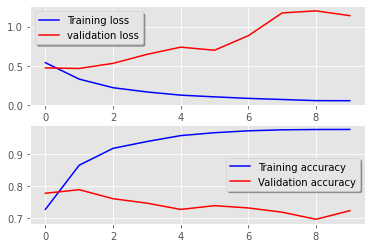

In [113]:
import matplotlib.pyplot as plt

# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

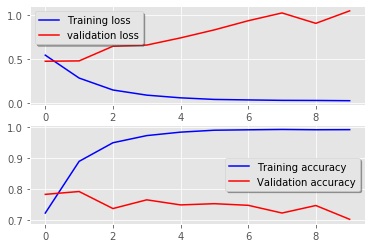

In [105]:
import matplotlib.pyplot as plt

# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

That doesn't look good. Our model clearly overfit !

In [114]:
model_loss = pd.DataFrame(model.history.history)
model_loss.head()

,val_loss,val_accuracy,loss,accuracy
0,0.473893,0.777413,0.540391,0.727094
1,0.466809,0.788575,0.330907,0.865189
2,0.531795,0.760341,0.221925,0.917734
3,0.646115,0.746553,0.167949,0.939080
4,0.737842,0.726855,0.127014,0.957635


In [55]:
model_loss = pd.DataFrame(model.history.history)
model_loss.head()

,val_loss,val_accuracy,loss,accuracy
0,1.089699,0.745896,0.024050,0.991133
1,1.001080,0.747866,0.020983,0.990969
2,1.083093,0.751806,0.019331,0.992282
3,1.131172,0.747209,0.019025,0.992282
4,1.167795,0.744583,0.016852,0.993432


<a id="6"></a> <br>
# 6.  First submission to Kaggle

In [13]:
testing_sequences2 = tokenizer.texts_to_sequences(test.text)
testing_padded2 = pad_sequences(testing_sequences2, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [14]:
predictions = model.predict(testing_padded2)

In [15]:
submission =  pd.read_csv("sample_submission.csv")

In [16]:
submission['target'] = (predictions > 0.5).astype(int)

In [17]:
submission.head()

,id,target
0,0,0
1,2,1
2,3,1
3,9,1
4,11,1


In [18]:
submission.to_csv("submission.csv", index=False, header=True)

I obtained 0.75 on Kaggle's submission score, not great. Maybe the Deep learning methods aren't that much specialised for database that small. 

<a id="4"></a> <br>
# 4. Machine Learning methods


Let's try the machine learning most classic packages :


- Decision Tree Model
- Gradient Boosting Model
- K - Nearest Neighbors Model
- Logistic Regression Model
- Stochastic Gradient Descent Model
- Support Vector Machine Model
- Bernoulli Naive Bayes Model
- Gaussian Naive Bayes Model
- Multinomial Naive Bayes Model
- Voting Classifier Model

In [40]:
train= pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

In [41]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import f1_score

Let's preprocessing the data with another methods but in a same way than for Deep Learning methods, to train.

In [42]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


### 4.1. Basic NLP Techniques

In [15]:
stop_words = set(stopwords.words('english'))
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
stemmer = EnglishStemmer()
lemmatizer = WordNetLemmatizer()

train['clean_text'] = train['text'].apply(lambda x : clean_text(x))


train['clean_text'] = train['clean_text'].apply(lambda x : clean(x))

Let's visualize our test before and after our cleaning :

In [16]:
train[['text', 'clean_text']].head()

,text,clean_text
0,Our Deeds are the Reason of this #earthquake M...,deed reason earthquak may allah forgiv us
1,Forest fire near La Ronge Sask. Canada,forest fire near la rong sask canada
2,All residents asked to 'shelter in place' are ...,resid ask shelter place notifi offic evacu she...
3,"13,000 people receive #wildfires evacuation or...",peopl receiv wildfir evacu order california
4,Just got sent this photo from Ruby #Alaska as ...,got sent photo rubi alaska smoke wildfir pour ...


We obtained the same result as before, let's see the most frequent word :

In [17]:
uniqueWordFrequents = {}
for tweet in train['clean_text']:
    for word in tweet.split():
        if(word in uniqueWordFrequents.keys()):
            uniqueWordFrequents[word] += 1
        else:
            uniqueWordFrequents[word] = 1
            
#Convert dictionary to dataFrame
uniqueWordFrequents = pd.DataFrame.from_dict(uniqueWordFrequents,orient='index',columns=['Word Frequent'])
uniqueWordFrequents.sort_values(by=['Word Frequent'], inplace=True, ascending=False)
uniqueWordFrequents.head(10)

,Word Frequent
like,404
fire,353
get,309
im,302
amp,296
bomb,227
new,224
via,220
dont,206
one,203


This time I will not use TfidfVectorizer but CountVectorizer instead :

In [18]:
counVec = CountVectorizer(max_features = uniqueWordFrequents.shape[0])
bagOfWords = counVec.fit_transform(train['clean_text']).toarray()

Let's split our data before modelling :

In [19]:
X = bagOfWords
y = train['target']
print("X shape = ",X.shape)
print("y shape = ",y.shape)

X_train , X_test , y_train , y_test = train_test_split(X, y, test_size=0.20, random_state=55, shuffle =True)
print('data splitting successfully')

X shape =  (7613, 11589)
y shape =  (7613,)
data splitting successfully


### 4.2. Building models

To begin with, let's take the most commonly used hyperparameters for our models ;

#### Decision Tree model

In [130]:
decisionTreeModel = DecisionTreeClassifier(criterion= 'entropy',
                                           max_depth = None, 
                                           splitter='best', 
                                           random_state=55)

decisionTreeModel.fit(X_train,y_train)

print("decision Tree Classifier model run successfully")

decision Tree Classifier model run successfully


#### GradientBoostingClassifier model

In [131]:
gradientBoostingModel = GradientBoostingClassifier(loss = 'deviance',
                                                   learning_rate = 0.01,
                                                   n_estimators = 100,
                                                   max_depth = 30,
                                                   random_state=55)

gradientBoostingModel.fit(X_train,y_train)

print("gradient Boosting Classifier model run successfully")

gradient Boosting Classifier model run successfully


#### KNeighborsClassifier model

In [132]:
KNeighborsModel = KNeighborsClassifier(n_neighbors = 7,
                                       weights = 'distance',
                                      algorithm = 'brute')

KNeighborsModel.fit(X_train,y_train)

print("KNeighbors Classifier model run successfully")

KNeighbors Classifier model run successfully


#### Logistic Regression model

In [133]:
LR = LogisticRegression(penalty='l2', 
                                        solver='saga', 
                                        random_state = 55)  

LR.fit(X_train,y_train)

print("LogisticRegression Classifier model run successfully")

LogisticRegression Classifier model run successfully


Before we move on with the others models, I would like to point out LIME, let me explain.

Recent times have seen a renewed focus on model interpretability. Machine Learning Experts are able to understand the importance of a model interpretability in it’s subsequent adaption by business. The problem with model explainability is that it’s very hard to define a model’s decision boundary in human understandable manner, especially with boosting model. LIME and eli5 are python libraries which tries to solve for model interpretability by producing locally faithful explanations. Below is an example of one such explanation for my NLP problem.

LIME use a representation that is understood by the humans irrespective of the actual features used by the model. This is coined as interpretable representation. An interpretable representation would vary with the type of data that we are working with for example :

- For text : It represents presence/absence of words.
- For image : It represents presence/absence of super pixels ( contiguous patch of similar pixels ).
- For tabular data : It is a weighted combination of columns

So let's see this.

In [79]:
import eli5
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
eli5.show_weights(LogisticRegression, vec=counVec, top=15,
                  target_names=['Not Disaster','Disaster'])

Weight?,Feature
+2.807,hiroshima
+2.341,earthquak
+2.145,wildfir
+1.850,suicid
+1.799,massacr
+1.768,typhoon
+1.696,train
+1.662,flood
+1.652,storm
+1.651,migrant


We can see the most impactful word (green word) who contributed most to Disaster comments and Red words who contributed to opposite class that is Not Disaster comments class.

The green word are quite obvious for detect disaster, or not, we can see earthquake, typhoon, storm and so on. 

Let's see one prediction in particular :

In [81]:
print(train['clean_text'][2])
print('\n')
print(y_train[2])

resid ask shelter place notifi offic evacu shelter place order expect


1


In [83]:
import eli5
eli5.show_prediction(LR, train['clean_text'][2], vec=counVec,
                     target_names=['Not Disaster','Disaster'],top=15)


Here, we can see the specific word the model use to make his probability. Like shelter or evacu, who tend to be quite the word we associate to disaster.

This package is absolutely wonderful to explain to non-iniate our models. So let's keep it in mind.

We can go on with our next models !

#### SGDClassifier model

In [134]:
SGD = SGDClassifier(loss = 'hinge', 
                              penalty = 'l1',
                              learning_rate = 'optimal',
                              random_state = 55, 
                              max_iter=100)

SGD.fit(X_train,y_train)

print("SGDClassifier Classifier model run successfully")

SGDClassifier Classifier model run successfully


#### SVCClassifier model

In [135]:
SVClassifier = SVC(kernel= 'linear',
                   degree=3,
                   max_iter=10000,
                   C=2, 
                   random_state = 55)

SVClassifier.fit(X_train,y_train)

print("SVClassifier model run successfully")

SVClassifier model run successfully


#### Bernoulli model

In [136]:
bernoulliNBModel = BernoulliNB(alpha=0.1)
bernoulliNBModel.fit(X_train,y_train)

print("bernoulliNB model run successfully")

bernoulliNB model run successfully


#### Gaussian model

In [137]:
gaussianNBModel = GaussianNB()
gaussianNBModel.fit(X_train,y_train)

print("gaussianNB model run successfully")

gaussianNB model run successfully


#### Multinomial model

In [138]:
multinomialNBModel = MultinomialNB(alpha=0.1)
multinomialNBModel.fit(X_train,y_train)

print("multinomialNB model run successfully")

multinomialNB model run successfully


#### VotingClassifier model

In [139]:
modelsNames = [('LogisticRegression',LR),
               ('SGDClassifier',SGD),
               ('SVClassifier',SVClassifier),
               ('bernoulliNBModel',bernoulliNBModel),
               ('multinomialNBModel',multinomialNBModel)]

VC = VotingClassifier(voting = 'hard',estimators= modelsNames).fit(X_train,y_train)
print("votingClassifier model run successfully")

votingClassifier model run successfully


<a id="7"></a> <br>
# 7.  Models performances

In [140]:
from sklearn import metrics

def roc_auc(predictions,target):
    '''
    This methods returns the AUC Score when given the Predictions
    and Labels
    '''
    
    fpr, tpr, thresholds = metrics.roc_curve(target, predictions)
    roc_auc = metrics.auc(fpr, tpr)
    return roc_auc

In [ ]:
scores = model_selection.cross_val_score(model, train_vectors, y, cv=3, scoring="f1")

In [26]:
#evaluation Details
models = [decisionTreeModel, gradientBoostingModel, KNeighborsModel, LR, 
          SGD, SVClassifier, bernoulliNBModel, gaussianNBModel, multinomialNBModel, VC]

for model in models :
    print(type(model).__name__,' Train Score is : ',model.score(X_train, y_train))
    print(type(model).__name__,' Test Score is  : ',model.score(X_test, y_test))
    
    y_pred = model.predict(X_test)
    
    print(type(model).__name__,' AUC is   : ' ,roc_auc(y_pred, y_test))
    
    print(type(model).__name__,' F1 Score is      : ' ,f1_score(y_test,y_pred))
    print('--------------------------------------------------------------------------')

DecisionTreeClassifier  Train Score is :  0.9862068965517241
DecisionTreeClassifier  Test Score is  :  0.6973079448456992
DecisionTreeClassifier  AUC is   :  0.6937042316258352
DecisionTreeClassifier  F1 Score is      :  0.6462010744435918
--------------------------------------------------------------------------
GradientBoostingClassifier  Train Score is :  0.8251231527093597
GradientBoostingClassifier  Test Score is  :  0.757715036112935
GradientBoostingClassifier  AUC is   :  0.7227973273942093
GradientBoostingClassifier  F1 Score is      :  0.6413994169096211
--------------------------------------------------------------------------
KNeighborsClassifier  Train Score is :  0.9862068965517241
KNeighborsClassifier  Test Score is  :  0.6539724228496389
KNeighborsClassifier  AUC is   :  0.6676570155902004
KNeighborsClassifier  F1 Score is      :  0.6382978723404256
--------------------------------------------------------------------------
LogisticRegression  Train Score is :  0.94417077

On the basis of our models performances, I think Bernoulli, Multinomial, Logistic Regression and VotingClassifier are my best pick.

Let's see, with a cross_validation, if those models generalize well.

In [ ]:
from sklearn import model_selection

cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0 )

#evaluation Details
models = [ LR, bernoulliNBModel, multinomialNBModel, VC]

for model in models :
    cv1 = model_selection.cross_validate(model, X, y, cv=cv_split, scoring="accuracy", return_train_score = True)
    
    print(type(model).__name__,' Train mean Accuracy is : ', cv1['train_score'].mean())
    print(type(model).__name__,' Test mean Accuracy is  : ', cv1['test_score'].mean())
    
    #y_pred = model.predict(X_test)
    
    cv2 = model_selection.cross_validate(model, X, y, cv=cv_split, scoring="roc_auc", return_train_score = True)
    
    print(type(model).__name__,' Train mean AUC is   : ' , cv2['train_score'].mean())
    print(type(model).__name__,' Test mean AUC is   : ' , cv2['test_score'].mean())
    
    
    cv3 = model_selection.cross_validate(model, X, y, cv=cv_split, scoring="f1", return_train_score = True)
    
    print(type(model).__name__,' Train mean F1 Score is      : ' , cv3['train_score'].mean())
    print(type(model).__name__,' Test mean F1 Score is      : ' , cv3['test_score'].mean())

    print('--------------------------------------------------------------------------')

LogisticRegression  Train mean Accuracy is :  0.9476680534267571
LogisticRegression  Test mean Accuracy is  :  0.7915061295971979
LogisticRegression  Train mean AUC is   :  0.9891668470022011
LogisticRegression  Test mean AUC is   :  0.8506824085017346
LogisticRegression  Train mean F1 Score is      :  0.9367387764742942
LogisticRegression  Test mean F1 Score is      :  0.7407399681691684
--------------------------------------------------------------------------
BernoulliNB  Train mean Accuracy is :  0.9397197284869717
BernoulliNB  Test mean Accuracy is  :  0.7804290718038529
BernoulliNB  Train mean AUC is   :  0.983459074199347
BernoulliNB  Test mean AUC is   :  0.8385039816418631
BernoulliNB  Train mean F1 Score is      :  0.9276764920435265
BernoulliNB  Test mean F1 Score is      :  0.7376980971919929
--------------------------------------------------------------------------
MultinomialNB  Train mean Accuracy is :  0.9377271731990364
MultinomialNB  Test mean Accuracy is  :  0.778108

Our picked models seems to generalize well, that's great.

<a id="8"></a> <br>
# 8.  Second Submission to Kaggle

In [142]:
from nltk.corpus import stopwords
import nltk
import re
import string, collections
from nltk.stem.snowball import EnglishStemmer
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words('english'))
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
stemmer = EnglishStemmer()
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower() #make text lowercase and fill na
    text = re.sub('\[.*?\]', '', text) 
    text = re.sub('\\n', '',str(text))
    text = re.sub("\[\[User.*",'',str(text))
    text = re.sub("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}",'',str(text))
    text = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text) #remove hyperlinks
    text = re.sub(r'\:(.*?)\:', '', text) #remove emoticones
    text = re.sub(r'[\w\.-]+@[\w\.-]+', '', str(text)) #remove email
    text = re.sub(r'(?<=@)\w+', '', text) #remove @
    text = re.sub(r'[0-9]+', '', text) #remove numbers
    text = re.sub("[^A-Za-z0-9 ]", '', text) #remove non alphanumeric like ['@', '#', '.', '(', ')']
    text = re.sub(r'[!"\$%&\'()*+,\-.\/:;=#@?\[\\\]^_`{|}~]*', '', text) #remove punctuations from sentences
    text = re.sub('<.*?>+', '', str(text))
    text = re.sub('[%s]' % re.escape(string.punctuation), '', str(text))
    text = re.sub('\w*\d\w*', '', str(text))
    text = tokenizer.tokenize(text)
    text = [word for word in text if not word in stop_words]
    #text = [lemmatizer.lemmatize(word) for word in text]
    text = [stemmer.stem(word) for word in text]
    final_text = ' '.join( [w for w in text if len(w)>1] ) #remove word with one letter
    return final_text

test['clean_text'] = test['text'].apply(lambda x : clean_text(x))
test['clean_text'] = test['clean_text'].apply(lambda x : clean(x))

In [143]:
#Create our dictionary 
uniqueWordFrequents = {}
for tweet in test['clean_text']:
    for word in tweet.split():
        if(word in uniqueWordFrequents.keys()):
            uniqueWordFrequents[word] += 1
        else:
            uniqueWordFrequents[word] = 1
            
#Convert dictionary to dataFrame
uniqueWordFrequents = pd.DataFrame.from_dict(uniqueWordFrequents,orient='index',columns=['Word Frequent'])
uniqueWordFrequents.sort_values(by=['Word Frequent'], inplace=True, ascending=False)
uniqueWordFrequents.head(10)

,Word Frequent
like,178
fire,158
get,145
amp,135
im,126
via,104
new,100
bomb,93
go,89
one,87


In [145]:
counVec = CountVectorizer(max_features = uniqueWordFrequents.shape[0])
bagOfWords = counVec.fit_transform(test['clean_text']).toarray()

In [ ]:
#counVec = CountVectorizer(max_features = uniqueWordFrequents.shape[0])
#bagOfWords = counVec.fit_transform(train['clean_text']).toarray()

#X = bagOfWords
#y = train['target']
#print("X shape = ",X.shape)
#print("y shape = ",y.shape)

#X_train , X_test , y_train , y_test = train_test_split(X, y, test_size=0.20, random_state=55, shuffle =True)
#print('data splitting successfully')

In [ ]:
from sklearn.linear_model import LogisticRegression
LogisticRegression = LogisticRegression(penalty='l2', solver='saga', random_state = 55).fit(X_train[:3263], y_train[:3263])
pred_test = LogisticRegression.predict(bagOfWords)

In [ ]:
sample_submission = pd.read_csv("sample_submission.csv")
sample_submission["target"] = pred_test
sample_submission.to_csv("submission3.csv", index=False)

## Web development

In order to have a concret and prompt outcome, I created a website to ensure that our model is useable by everyone.

I will share in our Github all the necessary files required fro creating it (app.py, templates, home and so on..)

There is the website where my model has been implemented : https://ml-deployment-evan.herokuapp.com/

And below, I put the serializer done with joblib for those who might be interested :

In [19]:
#All the package required to serialize

import process 
import process2

from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.pipeline import FeatureUnion

from sklearn.pipeline import Pipeline
import transfo
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
import pandas as pd

import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

Pipelines and Joblib have a hard time to cohabit, it appears that many people had difficulty to put on a website models built via pipeline. I took my inspiration from this article to deal with this issue : https://rebeccabilbro.github.io/module-main-has-no-attribute/

It seems that the key solution would be to create a file .py and put all the transformers required for our pipeline in here in order to charge them in our serializer and our app.py.

That's what I've done, I created a transfo.py, process.py and process2.py and put all my transformers there.

In [20]:
train= pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

In [21]:
y = train.target
X = train.text 

In [22]:
my_pipe = Pipeline([('t1', transfo.clean()),
                    ("counvec", CountVectorizer(max_features = 11601)),
                    ("classifier" , LogisticRegression(penalty='l2', solver='saga', random_state = 55))])

my_pipe.fit(X, y) 

Pipeline(memory=None,
     steps=[('t1', clean()), ('counvec', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=11601, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_word..., penalty='l2', random_state=55, solver='saga',
          tol=0.0001, verbose=0, warm_start=False))])

In [24]:
import joblib

# save the model to disk
joblib.dump(my_pipe,'final_pipeline.joblib')

['final_pipeline.joblib']

And here it is, our serialized model, ready for use here -> https://ml-deployment-evan.herokuapp.com/